In [1]:

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

from future.builtins import *  # NOQA
from datetime import timedelta
from obspy.core import read
from obspy import read_inventory
from obspy.geodetics import locations2degrees, degrees2kilometers
from obspy.core.utcdatetime import UTCDateTime
from obspy.core.inventory import read_inventory
import numpy as np
#from obspy.clients.fdsn.client import Client
from pdart.util import linear_interpolation, timing_correction
#from pdart.extra_plots.plot_timing_divergence import plot_timing

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 4
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['font.size'] = 12
SECONDS_PER_DAY=3600.*24

In [2]:
def raw_seismogram(station = 's14', starttime_str='1973-03-13T07:30:00.0',endtime_str ='1973-03-13T09:30:00.0'):
    # station='S14'
    # channel='MH1'
    # location='*'
    year  = starttime_str[0:4]
    starttime = UTCDateTime(starttime_str)
    endtime = UTCDateTime(endtime_str)

    #print(client)
    
   # stream = client.get_waveforms(network=network, station=station, channel=channel, location=location, starttime=starttime, endtime=endtime)
    for i in range(72, 366):
        day_str = f"{i:03}"  # format the number into a three-digit string
        url = f"https://pds-geosciences.wustl.edu/lunar/urn-nasa-pds-apollo_pse/data/xa/continuous_waveform/{station}/{year}/{day_str}/xa.{station}.00.mh1.1973.{day_str}.0.mseed"
        st = read(url)
        sliced_st = st.slice(starttime, endtime)
        print("Checking day", i, "of 365", end='\r')
        if len(sliced_st) > 0:  # Check if sliced_st is not empty
            sliced_st.plot(equal_scale=False, size=(1000, 600), method='full')
            break
    if st is None:
        raise Exception("No data found for the provided time range.")
    return st

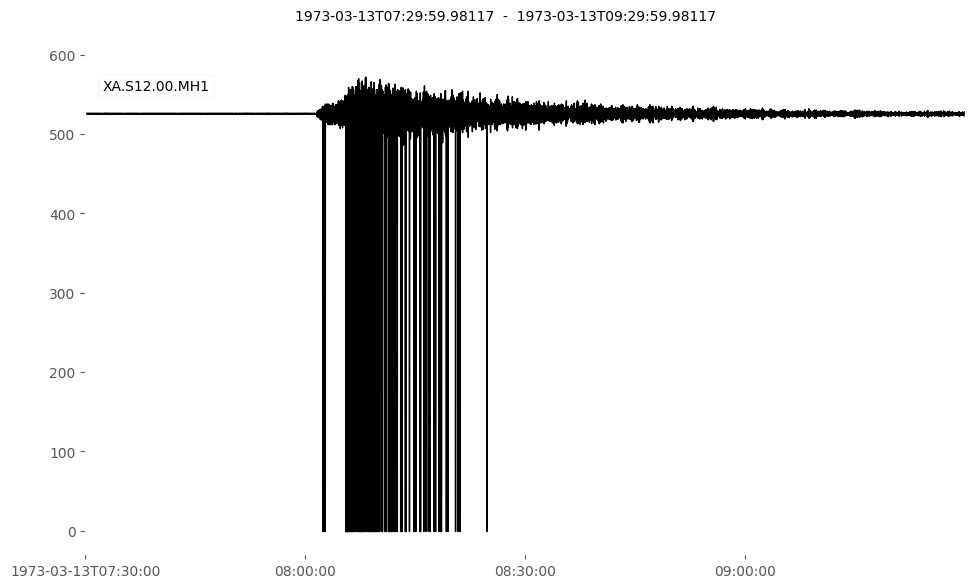

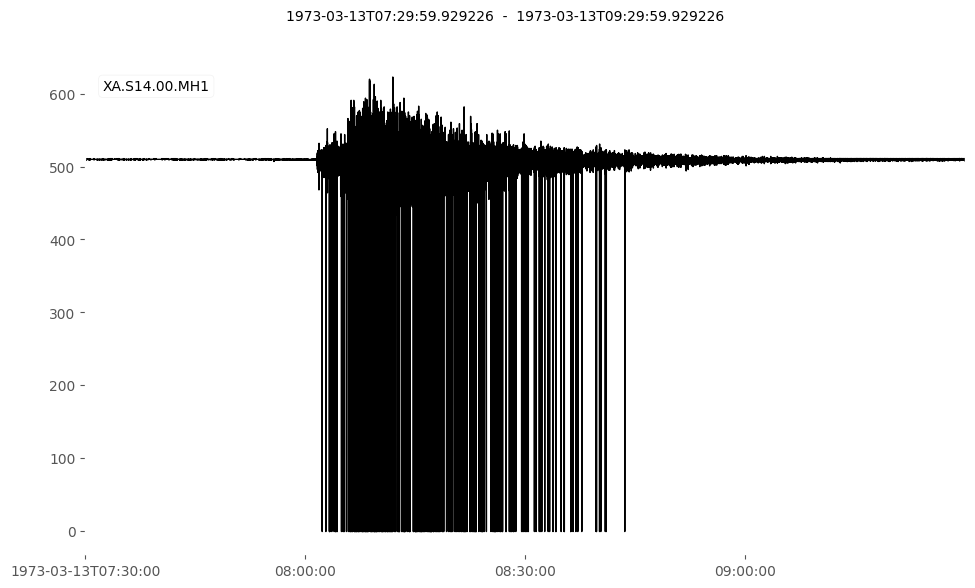

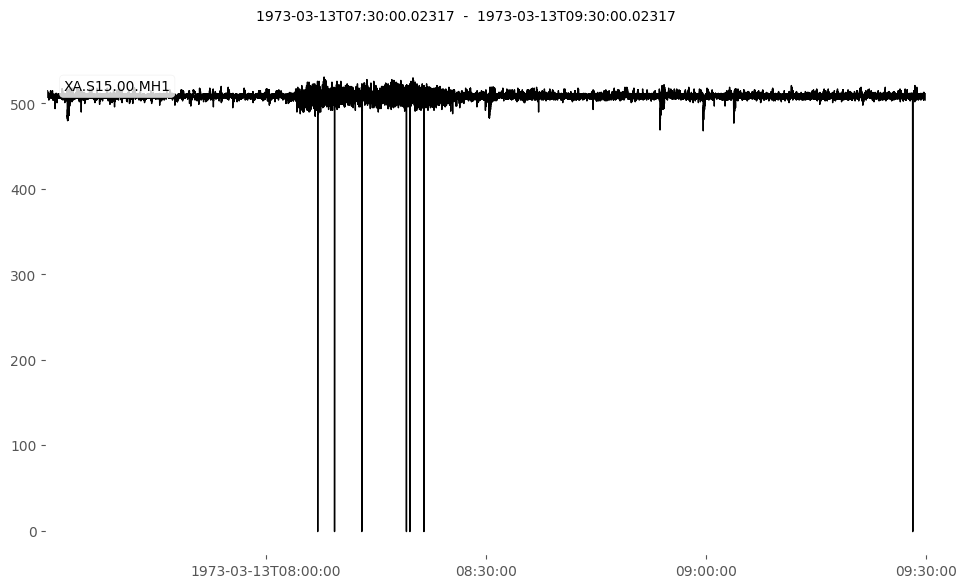

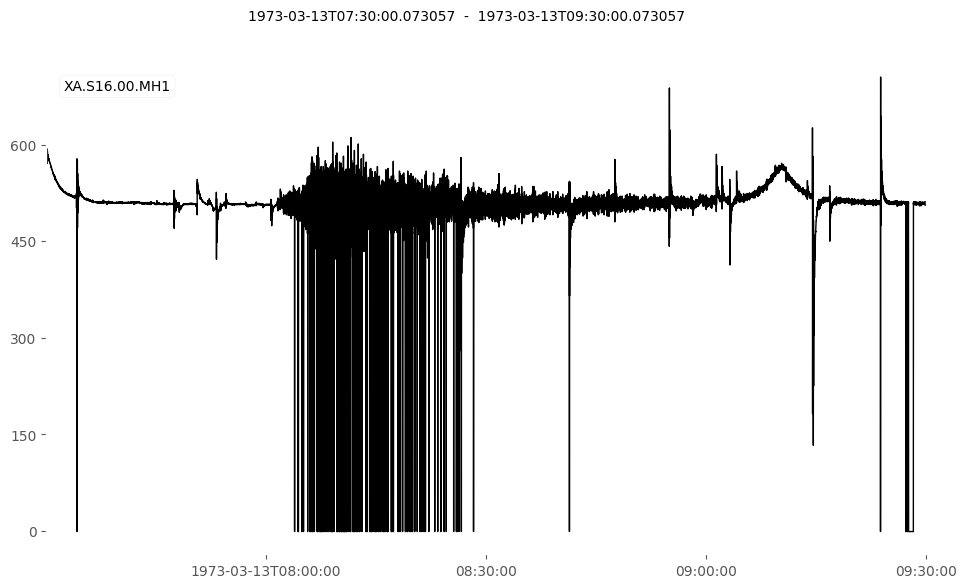

In [3]:
stream1 = raw_seismogram('s12')
stream2 = raw_seismogram('s14')
stream3 = raw_seismogram('s15')
stream4 = raw_seismogram('s16')

In [5]:
def view_Apollo(stream=None,starttime= UTCDateTime('1973-03-13T07:30:00.0'),endtime = UTCDateTime('1973-03-13T09:30:00.0'),
  network='XA',station='S14',channel='MH1',location='*',plot_seismogram=True,plot_response=False):
    #else:
    inv = read_inventory("https://pds-geosciences.wustl.edu/lunar/urn-nasa-pds-apollo_pse/data/xa/metadata/stationxml.xa.0.sxml", format="STATIONXML")
    sliced_st = stream.trim(starttime=starttime,endtime=endtime)
        
    
    for tr in stream:
        # interpolate across the gaps of one sample 
        linear_interpolation(tr,interpolation_limit=1)
    stream.merge()
    
    for tr in stream:
        # optionally interpolate across any gap 
        # for removing the instrument response from a seimogram, 
        # it is useful to get a mask, then interpolate across the gaps, 
        # then mask the trace again. 
        if tr.stats.channel in ['MH1', 'MH2', 'MHZ']:

            # add linear interpolation but keep the original mask
            original_mask = linear_interpolation(tr,interpolation_limit=None)
            # remove the instrument response
            pre_filt = [0.1,0.3,0.9,1.1]
            tr.remove_response(inventory=inv, pre_filt=pre_filt, output="DISP",
                       water_level=None, plot=plot_response)
            if plot_response:
                plt.show()
            # apply the mask back to the trace 
            tr.data = np.ma.masked_array(tr, mask=original_mask)

        elif tr.stats.channel in ['SHZ']:

            # add linear interpolation but keep the original mask
            original_mask = linear_interpolation(tr,interpolation_limit=None)
            # remove the instrument response
            pre_filt = [1,2,11,13] 
            tr.remove_response(inventory=inv, pre_filt=pre_filt, output="DISP",
                       water_level=None, plot=plot_response)
            if plot_response:
                plt.show()
            
            # apply the mask back to the trace 
            tr.data = np.ma.masked_array(tr, mask=original_mask)

    if plot_seismogram:
        stream.plot(equal_scale=False,size=(1000,600),method='full')

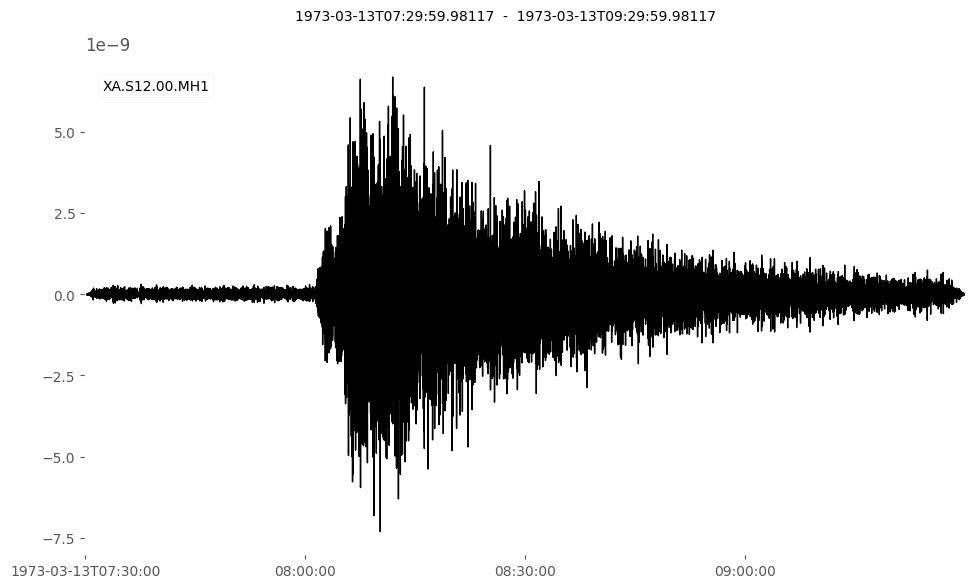

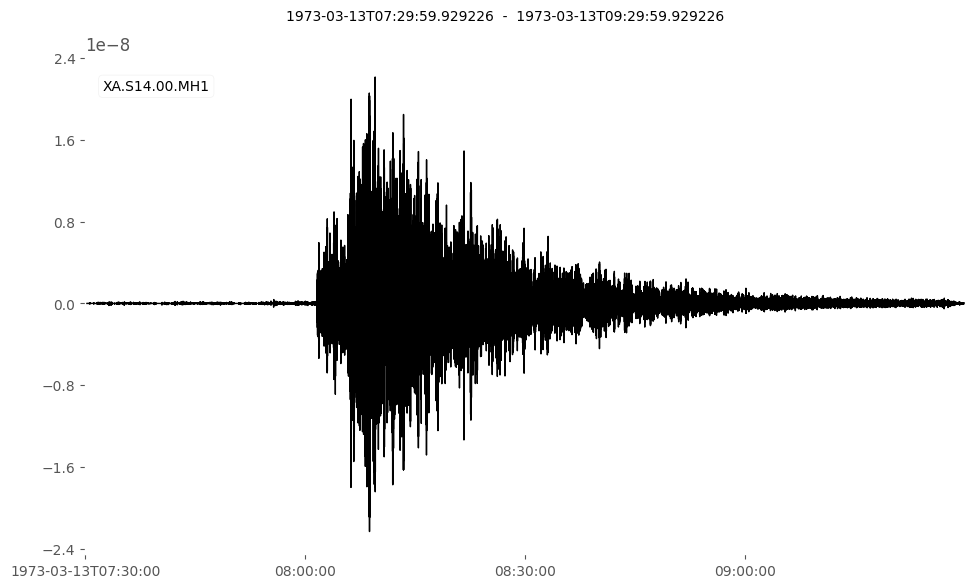

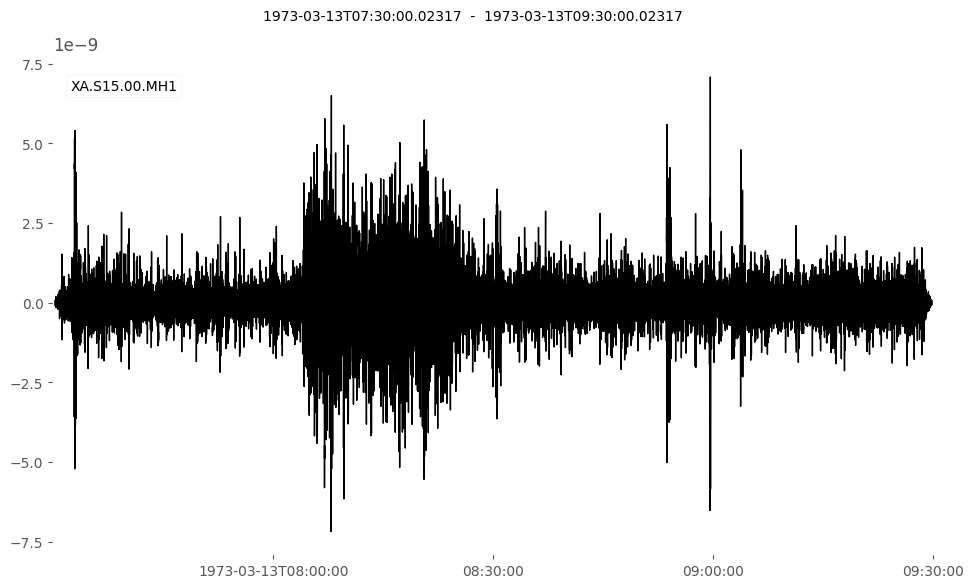

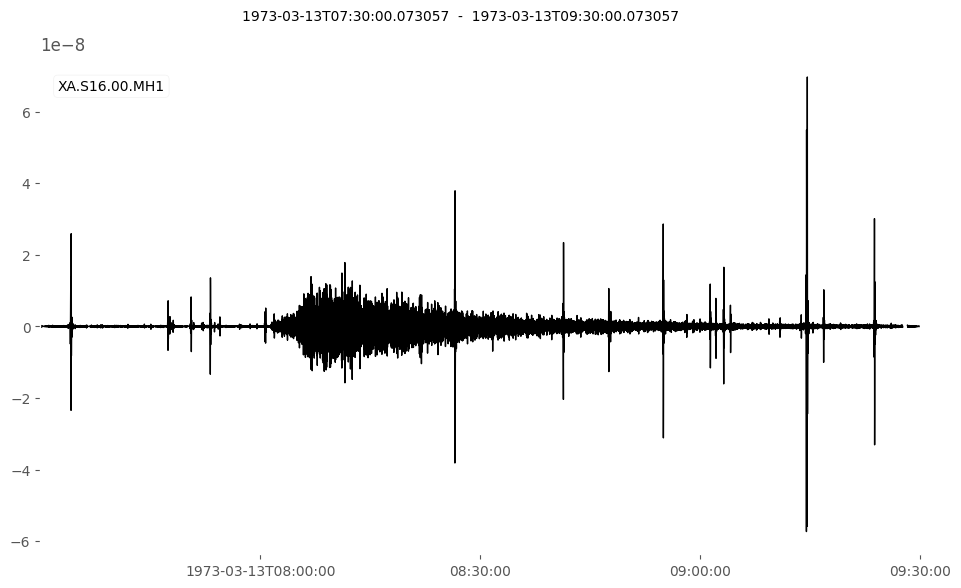

In [6]:
view_Apollo(stream1)
view_Apollo(stream2)
view_Apollo(stream3)
view_Apollo(stream4)

In [80]:
from math import log10
def convert_du_to_magnitude(du, mode="peaked"):
    """
    Convert digital units (DU) to magnitude on the Richter scale.
    
    Parameters:
    - du (int or float): Digital unit value.
    - mode (str): Either 'peaked' or 'flat' indicating the response mode.
    
    Returns:
    - Richter scale magnitude (float)
    """
    
    # Convert DU to displacement in nm
    if mode == "peaked":
        displacement_nm = du * 0.08
    elif mode == "flat":
        displacement_nm = du * 0.3
    else:
        raise ValueError("Invalid mode. Choose either 'peaked' or 'flat'.")
    
    # Convert displacement from nm to mm
    displacement_mm = abs(displacement_nm * 1e-6)
    
    # Compute the Richter scale magnitude
    A0 = 0.001  # Reference amplitude in mm
    M_L = (log10(displacement_mm) - log10(A0))
    
    return M_L

In [88]:
from obspy import UTCDateTime

def get_magnitudes_from_stream(st, starttime_str='1973-03-13T07:30:00.0', endtime_str='1973-03-13T09:30:00.0'):
    """Extract magnitudes from a stream."""
    starttime = UTCDateTime(starttime_str)
    endtime = UTCDateTime(endtime_str)

    # Slice the stream for the provided time range
    sliced_st = st.slice(starttime, endtime)
    
    # Check if there's data in the sliced stream
    if len(sliced_st) == 0:
        raise Exception("No data found for the provided time range.")
    
    # Extract time and magnitude/data from the stream
    times = sliced_st[0].times(type="timestamp")  # Get times as UNIX timestamps
    magnitudes = sliced_st[0].data.tolist()
    #clean all the none values
    magnitudes = [m for m in magnitudes if m is not None]

    time_magnitude_pairs = [(t, m) for t, m in zip(times, magnitudes)]
    
    return time_magnitude_pairs


In [89]:
s12_magnitudes = get_magnitudes_from_stream(stream1)
s14_magnitudes = get_magnitudes_from_stream(stream2)
s15_magnitudes = get_magnitudes_from_stream(stream3)
s16_magnitudes = get_magnitudes_from_stream(stream4)

inv = read_inventory("https://pds-geosciences.wustl.edu/lunar/urn-nasa-pds-apollo_pse/data/xa/metadata/stationxml.xa.0.sxml", format="STATIONXML")
s12_coordinates = inv.get_coordinates('XA.S12.00.MH1')
s14_coordinates = inv.get_coordinates('XA.S14.00.MH1')
s15_coordinates = inv.get_coordinates('XA.S15.00.MH1')
s16_coordinates = inv.get_coordinates('XA.S16.00.MH1')

s16_magnitudes

[(100855800.07305661, 5.450451514760824e-11),
 (100855800.224, 3.815329163034515e-11),
 (100855800.3749434, 1.925329911341837e-11),
 (100855800.5258868, -1.3834609459846572e-14),
 (100855800.67683019, -1.776404022888744e-11),
 (100855800.82777359, -3.314357057822697e-11),
 (100855800.97871698, -4.6230441987823205e-11),
 (100855801.12966038, -5.732493102824685e-11),
 (100855801.28060378, -6.629302398076689e-11),
 (100855801.43154718, -7.251030681863025e-11),
 (100855801.58249056, -7.539958497396482e-11),
 (100855801.73343396, -7.503754561478471e-11),
 (100855801.88437736, -7.225705594487317e-11),
 (100855802.03532076, -6.812442322874497e-11),
 (100855802.18626416, -6.322945342933171e-11),
 (100855802.33720756, -5.740157190641245e-11),
 (100855802.48815095, -5.00961986740249e-11),
 (100855802.63909434, -4.109678711546966e-11),
 (100855802.79003774, -3.087949613729603e-11),
 (100855802.94098113, -2.0274429239760096e-11),
 (100855803.09192453, -9.703447086346008e-12),
 (100855803.24286793,

In [90]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def plot_concentric_circles(magnitudes, indices):
    # Normalize the magnitudes to [0,1] for coloring
    abs_magnitudes = [abs(m) for m in magnitudes]
    #Get the max magnitude with some padding
    # max_magnitude = max(abs_magnitudes)
    #get second max magnitude
    second_max_magnitude = sorted(abs_magnitudes)[-1]
    max_magnitude = second_max_magnitude
    print(max_magnitude)
    normalized_magnitudes = [m / max_magnitude + 0.2 for m in abs_magnitudes] 

    # Sort indices to determine circle radii
    sorted_indices = sorted(indices)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_aspect('equal', 'box')

    # Plot each circle
    for i, idx in enumerate(sorted_indices):
        # Set circle radius based on its position in sorted indices
        radius = (i+1)/len(sorted_indices)

        # Set circle color based on its normalized magnitude
        color = plt.cm.seismic(1 - (i/len(sorted_indices)))
        #Have alpha fade out as i increases
        alpha = 1 - (i/len(sorted_indices))

        circle = plt.Circle((0, 0), radius, color=color, alpha=alpha, linewidth=1, fill=False)
        ax.add_patch(circle)

    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.axis("off")
    plt.title("Concentric Circles Colored by Magnitude")
    plt.show()

#Get every 10th magnitude
magnitudes2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
indices = list(range(0, len(magnitudes), 100))
plot_concentric_circles(magnitudes, indices)



NameError: name 'magnitudes' is not defined

In [85]:
#check if s16 has any None data types
#s16_magnitudes
c = 0
for i in range(len(s16_magnitudes)):
    if s16_magnitudes[i][1] is None:
        c+=1
print(c)

0


<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
5 5


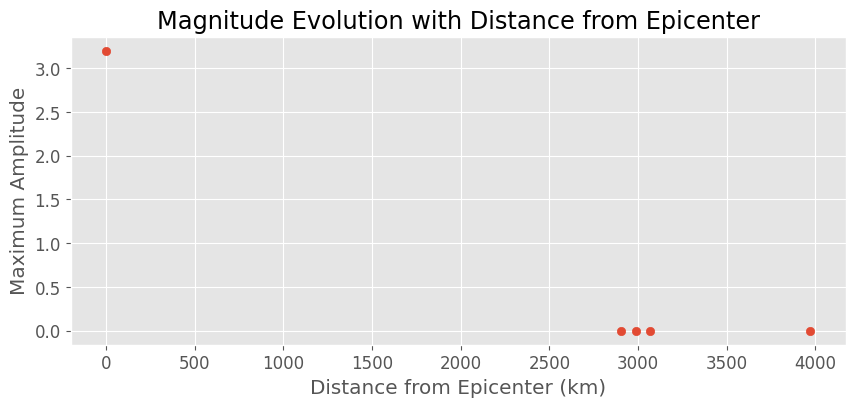

In [91]:
import math
import matplotlib.pyplot as plt

def haversine(lat1, lon1, lat2, lon2):
    R = 1740 #1079.6
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * 
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c
    return d

def plot_magnitude_evolution(epicenter, seismometer_data):
    """
    :param epicenter: tuple containing latitude and longitude of the earthquake's epicenter
    :param seismometer_data: list of tuples. Each tuple contains:
                             (latitude, longitude, list of measurements).
                             Each measurement is a tuple of (time, amplitude).
    """
    
    distances = []
    amplitudes = []

    for data in seismometer_data:
        lat, lon, measurements = data
        # Calculate the distance from the epicenter to the seismometer
        print(type(measurements))
        distance = haversine(epicenter[0], epicenter[1], lat, lon)
        
        max_amplitude = max(measurements, key=lambda x: x[1])[1]
        
        distances.append(distance)
        amplitudes.append(max_amplitude)
    print(len(distances), len(amplitudes))
    # Plotting the data
    plt.scatter(distances, amplitudes)
    plt.title('Magnitude Evolution with Distance from Epicenter')
    plt.xlabel('Distance from Epicenter (km)')
    plt.ylabel('Maximum Amplitude')
    plt.grid(True)
    plt.show()

# Example usage
epicenter = (34.0522, -118.2437)  # Sample epicenter
seismometer_data = [
    (epicenter[0], epicenter[1], [(0, 3.2)]),
    (s12_coordinates['latitude'], s12_coordinates['longitude'], s12_magnitudes),
    (s14_coordinates['latitude'], s14_coordinates['longitude'], s14_magnitudes),
    (s15_coordinates['latitude'], s15_coordinates['longitude'], s15_magnitudes),
    (s16_coordinates['latitude'], s16_coordinates['longitude'], s16_magnitudes)
    # ... Add more seismometer data as needed
]
plot_magnitude_evolution(epicenter, seismometer_data)


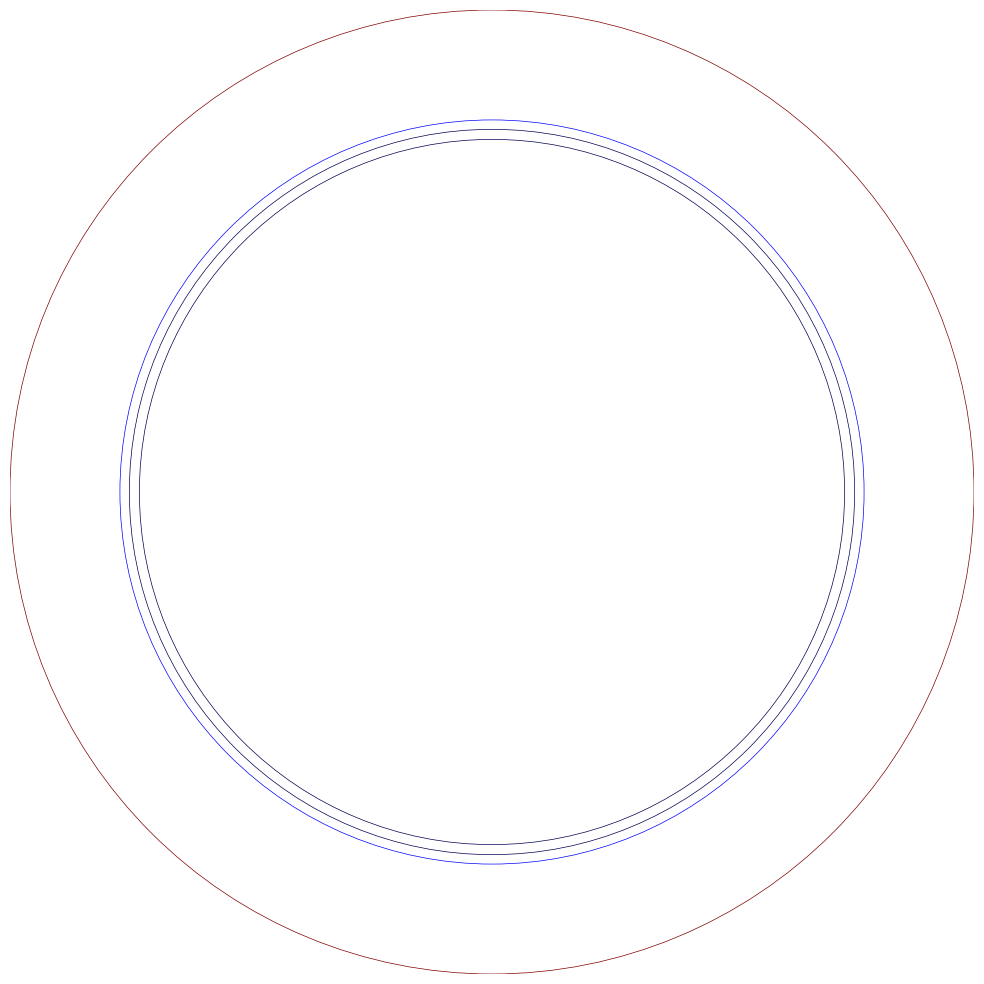

In [92]:
def plot_seismic_rings(epicenter, seismometer_data):
    """
    :param epicenter: tuple containing latitude and longitude of the earthquake's epicenter.
    :param seismometer_data: list of tuples. Each tuple contains:
                             (latitude, longitude, list of measurements).
                             Each measurement is a tuple of (time, amplitude).
    """

    # Create a colormap for seismic data
    cmap = plt.get_cmap('seismic')
    norm = mcolors.Normalize(vmin=min([max(data[2], key=lambda x: x[1])[1] for data in seismometer_data]), 
                             vmax=max([max(data[2], key=lambda x: x[1])[1] for data in seismometer_data]))

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_aspect('equal', 'box')
    
    # Sort the seismometer data by distance in descending order
    sorted_data = sorted(seismometer_data, key=lambda data: haversine(epicenter[0], epicenter[1], data[0], data[1]), reverse=True)

    for data in sorted_data:
        lat, lon, measurements = data
        
        # Calculate the distance from the epicenter to the seismometer
        distance = haversine(epicenter[0], epicenter[1], lat, lon)
        if distance == 0:
            distance = 1
        # Extract max amplitude from the measurements
        max_amplitude = max(measurements, key=lambda x: x[1])[1]

        circle = plt.Circle((0, 0), distance, color=cmap(norm(max_amplitude)), fill=True)
        ax.add_artist(circle)

    ax.set_xlim([-max([haversine(epicenter[0], epicenter[1], data[0], data[1]) for data in sorted_data]),
                 max([haversine(epicenter[0], epicenter[1], data[0], data[1]) for data in sorted_data])])
    ax.set_ylim([-max([haversine(epicenter[0], epicenter[1], data[0], data[1]) for data in sorted_data]),
                 max([haversine(epicenter[0], epicenter[1], data[0], data[1]) for data in sorted_data])])

    ax.axis('off')  # Turn off the axis
    plt.tight_layout()

    # Save the figure
    plt.savefig('seismic_rings.png', dpi=300)
    plt.show()


# Sample usage (using the haversine function from the previous response):
epicenter = (34.0522, -118.2437)  # Sample epicenter
seismometer_data = [
    (s12_coordinates['latitude'], s12_coordinates['longitude'], s12_magnitudes),
    (s14_coordinates['latitude'], s14_coordinates['longitude'], s14_magnitudes),
    (s15_coordinates['latitude'], s15_coordinates['longitude'], s15_magnitudes),
    (s16_coordinates['latitude'], s16_coordinates['longitude'], s16_magnitudes)
    # ... Add more seismometer data as needed
]
plot_seismic_rings(epicenter, seismometer_data)
